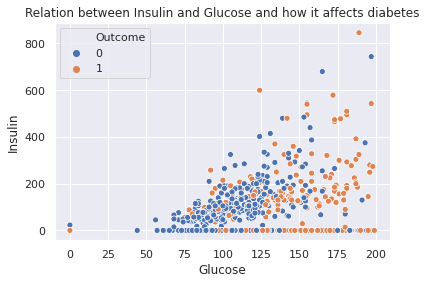

One of the viusalization from the dataset. 


# Context


This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

# Content 


The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

# Goal 

Can you build a machine learning model to accurately predict whether or not the patients in the dataset have diabetes or not?



Importing and reading the requited files 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('./diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set(style='darkgrid')

## First we need to do the feature engineering and data visualization 



<AxesSubplot:>

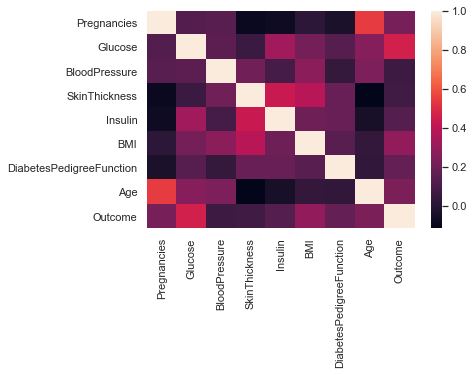

In [4]:
sns.heatmap(df.corr())

Conclusion from the correlation matrix:-
    1. Glucose level plays the most important role in determining the whether the person is diabetic or not.
    2. After that, BMI, pregnancy and Age plays the second most important role. 
    3. Third comes insulin and DiabetesPedigreeFunction. 
    4. And finally all other factors plays minor role as well. 

Lets analyse the dataset a little more. You can skip the data visualization and exploratory data analysis after this and jump directly into the 'ANN with pytorch' section if you are not interested. 

In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

So there is no nan or missing values in the dataset.


In [6]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

From the above observation we can say that the dataset is not imbalanced as one type of outcome does not dominate the dataset completely

In [7]:
Glucose_mean = df.groupby('Outcome').Glucose.mean()
Glucose_min = df.groupby('Outcome').Glucose.min()
Glucose_max = df.groupby('Outcome').Glucose.max()
print('Mean value of glucose of people affected and not affected with diabetes', Glucose_mean)
print('Minimum value of glucose of people affected and not affected with diabetes', Glucose_min)
print('Maximum value of glucose of people affected and not affected with diabetes', Glucose_max)

Mean value of glucose of people affected and not affected with diabetes Outcome
0    109.980000
1    141.257463
Name: Glucose, dtype: float64
Minimum value of glucose of people affected and not affected with diabetes Outcome
0    0
1    0
Name: Glucose, dtype: int64
Maximum value of glucose of people affected and not affected with diabetes Outcome
0    197
1    199
Name: Glucose, dtype: int64


So from the above data things that we can conclude are :-
1. People with higher glucose level has more chances of diabetes as the mean value suggests
2. However someone with zero glucose level can also be affected with diabetes. 
3. And someone with very high glucose level around 197 may not suffer from diabetes. 

Text(0.5, 1.0, 'Relation between Insulin and Glucose and how it affects diabetes')

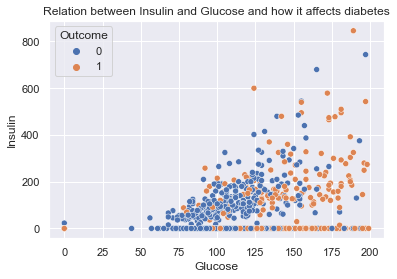

In [8]:
sns.scatterplot(x = 'Glucose',y = 'Insulin', hue = 'Outcome', data=df)
plt.title('Relation between Insulin and Glucose and how it affects diabetes')

C:\Users\niranjans3ln\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Insulin column in the dataset')

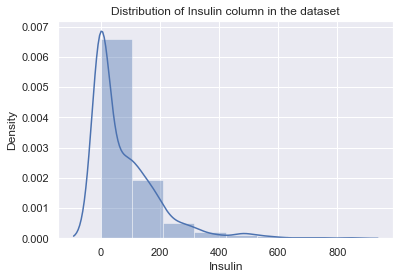

In [9]:
sns.distplot(df['Insulin'],bins = 8)
plt.title('Distribution of Insulin column in the dataset')

C:\Users\niranjans3ln\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Pregnancies', ylabel='count'>

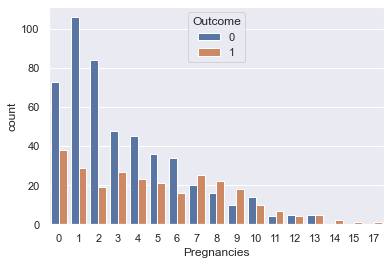

In [10]:
sns.countplot(df['Pregnancies'],hue=df['Outcome'])

Text(0.5, 1.0, 'Box Plot')

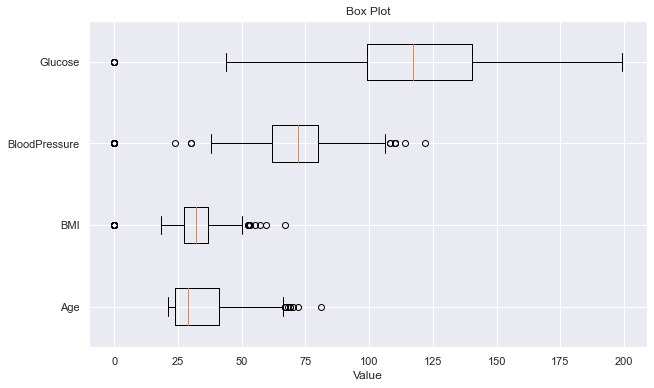

In [11]:
plt.figure(figsize=(10,6))
plt.boxplot([df['Age'], df['BMI'], df['BloodPressure'], df['Glucose']], vert=False)
plt.yticks([1, 2, 3, 4], ['Age', 'BMI', 'BloodPressure', 'Glucose'])
plt.xlabel('Value')
plt.title("Box Plot")

It is clear from the box plot that there are many outliers. We will see whether they affect the prediction or not

Text(0.5, 1.0, 'Relation between glucose level and BMI and how it affects diabetes')

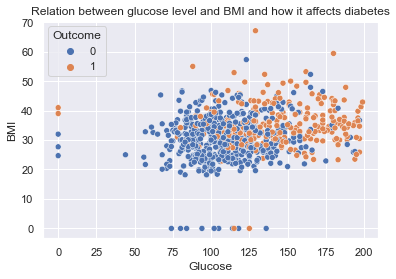

In [12]:
sns.scatterplot(x=df['Glucose'], y=df['BMI'], hue=df['Outcome'])
plt.title('Relation between glucose level and BMI and how it affects diabetes')

## ANN with Pytorch 

- Pytorch is basically a library that uses tensors to build neural network. A tensor in pytorch is pretty similar to a numpy array but it can use the power of the GPU.


The neural network that I am going to create will have three layers 
- hidden layer 1 - 20 neurons 
- hidden layer 2 - 10 neurons
- hidden layer 3 - 5 neurons 

In [13]:
# Taking all the dependent variables in x and all the independent variables in y 

X=df.drop('Outcome',axis=1).values
y=df['Outcome'].values

In [14]:
# Making a 80:20 train test split

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

X_train.shape

(614, 8)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

The first step towards creating the model is to create a tensor out of the pandas dataframe or numpy array.

In [16]:
##### Creating Tensors
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)

f_connected in this case means fully connected layer 

In [17]:
class ANN_Model(nn.Module):
    def __init__(self,input_features=8,hidden1=8,hidden2=4,hidden3=3,out_features=2):
        super().__init__()
        self.f_connected1=nn.Linear(input_features,hidden1)
        self.f_connected2=nn.Linear(hidden1,hidden2)
        self.f_connected3=nn.Linear(hidden2,hidden3)
        self.out=nn.Linear(hidden3,out_features)
    def forward(self,x):
        x=F.relu(self.f_connected1(x))
        x=F.relu(self.f_connected2(x))
        x=F.relu(self.f_connected3(x))
        x=self.out(x)
        return x

In [18]:
torch.manual_seed(20)
model=ANN_Model()
# torch.manual_seed() fixes the random value to a certain value and does not change the value everytime one reruns it

In [19]:
model.parameters

<bound method Module.parameters of ANN_Model(
  (f_connected1): Linear(in_features=8, out_features=8, bias=True)
  (f_connected2): Linear(in_features=8, out_features=4, bias=True)
  (f_connected3): Linear(in_features=4, out_features=3, bias=True)
  (out): Linear(in_features=3, out_features=2, bias=True)
)>

In [20]:
###Backward Propogation-- Define the loss_function,define the optimizer
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

In [21]:
epochs=500
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model.forward(X_train)
    loss=loss_function(y_pred,y_train)
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 2.4310476779937744
Epoch number: 11 and the loss : 0.7037491202354431
Epoch number: 21 and the loss : 0.6875187158584595
Epoch number: 31 and the loss : 0.6665370464324951
Epoch number: 41 and the loss : 0.6555007696151733
Epoch number: 51 and the loss : 0.6457864046096802
Epoch number: 61 and the loss : 0.6326268315315247
Epoch number: 71 and the loss : 0.6165886521339417
Epoch number: 81 and the loss : 0.6029781103134155
Epoch number: 91 and the loss : 0.591734766960144
Epoch number: 101 and the loss : 0.5803649425506592
Epoch number: 111 and the loss : 0.5697128176689148
Epoch number: 121 and the loss : 0.5570443868637085
Epoch number: 131 and the loss : 0.5454198718070984
Epoch number: 141 and the loss : 0.5362595319747925
Epoch number: 151 and the loss : 0.526863694190979
Epoch number: 161 and the loss : 0.5177904963493347
Epoch number: 171 and the loss : 0.508303165435791
Epoch number: 181 and the loss : 0.4988637864589691
Epoch number: 191 and the 

In [22]:
### plot the loss function
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
tensor.detach().numpy()

NameError: name 'tensor' is not defined

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

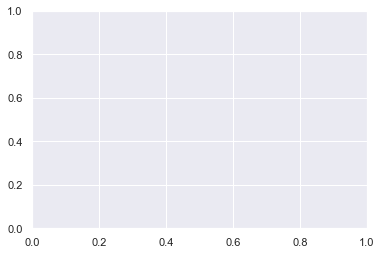

In [28]:
plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [24]:
predictions=[]
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred=model(data)
        predictions.append(y_pred.argmax().item())

In [25]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,predictions)
score

0.7987012987012987